## **Guns Detection**





 Mount your google drive to colab 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Enabling and testing the GPU

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Observe TensorFlow speedup on GPU relative to CPU

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
    
cpu()
gpu()

print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number = 10, setup = "from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number = 10, setup = "from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
2.6120138739997856
GPU (s):
0.04148182300014014
GPU speedup over CPU: 62x


Import necessary libraries



In [6]:
import os
# provides functions for interacting with the operating system. OS comes under Python's standard utility modules.

import cv2
# bindings designed to solve computer vision problems

import numpy as np
# providing support for large multidimensional arrays and matrices along with a collection of high-level mathematical functions to execute functions swiftly. 

import pandas as pd
# enable the provision of easy data structure and quicker data analysis for Python. For operations like data analysis and modelling

import matplotlib.pyplot as plt
# provides a dimensional plotting, widely used for quality figures in a variety of hard copy formats and interactive environments across platforms. 

from google.colab.patches import cv2_imshow 
# for image display in google colab notebook

In [7]:
from sklearn.model_selection import train_test_split
# Split arrays or matrices into random train and test subsets

from tensorflow.keras.applications.inception_v3 import InceptionV3
# instantiates the Inception v3 architecture

from tensorflow.keras.preprocessing import image
# set of tools for real-time data augmentation on image data.

from tensorflow.keras.models import Model, Sequential
# the architecture, or configuration, which specifies what layers the model contain, and how they're connected.

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# global average pooling operation for spatial data.
# dense is a regular densely-connected Neural Network layer.

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# a callback is an object that can perform actions at various stages of training.

from keras.utils import to_categorical
# converts a class vector (integers) to binary class matrix.

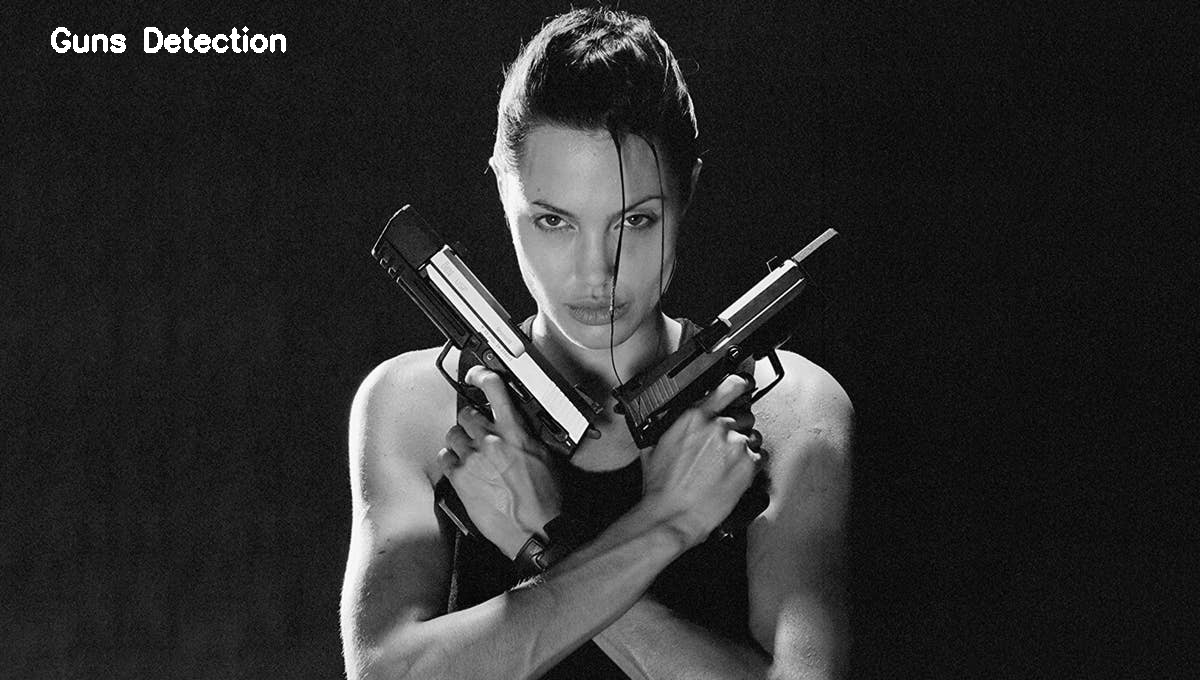

In [ ]:
img_path = '/content/gdrive/MyDrive/Guns_Detection/tomb_raider.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
font = cv2.FONT_HERSHEY_SIMPLEX 
org = (50, 50) 
fontScale = 1
color = (255, 0, 0) 
thickness = 4
image = cv2.putText(img, 'Guns Detection', org, font, fontScale, color, thickness, cv2.COLOR_BGR2GRAY) 
cv2_imshow(image)

Function will read an image and convert to a specified version and resize depending on which algorithm is being used - in our case we using incepotion V3.

In [8]:
def get_image_value(path, dim): 
    img = image.load_img(path, target_size = dim)
    img = image.img_to_array(img)
    return img / 255

Function will take a list of image paths and returns the np array corresponding to each image. It also takes the dim and whether edge is specified in order to pass it to another function to apply these parameters. Uses get_image_value to perform these operations

In [9]:
def get_image_array(img_paths, dim): 
    final_array = []
    from tqdm import tqdm
    for path in tqdm(img_paths):
        img = get_image_value(path, dim)
        final_array.append(img)
    final_array = np.array(final_array)  
    return final_array

Function will create train and test split

In [ ]:
def split_train_test():
    dim = (224, 224) 
    np.random.seed(10)  

    gun_paths = [f'/content/gdrive/MyDrive/Guns_Detection/Weapon/{i}' for i in os.listdir('/content/gdrive/MyDrive/Guns_Detection/Weapon')] 
    gun_labels = [1 for i in range(len(gun_paths))]
    no_gun_paths = [f'/content/gdrive/MyDrive/Guns_Detection/NoWeapon/{i}' for i in os.listdir('/content/gdrive/MyDrive/Guns_Detection/NoWeapon')]
    no_gun_labels = [0 for i in range(len(no_gun_paths))]
    
    np.random.shuffle(gun_paths)
    np.random.shuffle(no_gun_paths)

    paths = gun_paths + no_gun_paths
    labels = gun_labels + no_gun_labels

    x_train, x_test, y_train, y_test = train_test_split(paths, labels, stratify = labels, train_size = .75, random_state = 10)

    new_x_train = get_image_array(x_train, dim)
    new_x_test = get_image_array(x_test, dim)
    
    print('\nTrain Value Counts')
    print(pd.Series(y_train).value_counts())
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('Test Value Counts')
    print(pd.Series(y_test).value_counts())
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('X Train Shape')
    print(new_x_train.shape)
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('X Test Shape')
    print(new_x_test.shape)
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

    y_train = np.array(y_train)
    y_test = np.array(y_test)
    y_test = to_categorical(y_test)
    y_train = to_categorical(y_train)
    train_test = (new_x_train, new_x_test, y_train, y_test)
    return train_test

x_train, x_test, y_train, y_test = split_train_test()

100%|██████████| 2027/2027 [00:04<00:00, 493.87it/s]



Train Value Counts
1    3224
0    2855
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Test Value Counts
1    1075
0     952
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
X Train Shape
(6079, 224, 224, 3)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
X Test Shape
(2027, 224, 224, 3)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Show random image from train dataset

label 1 -> gun


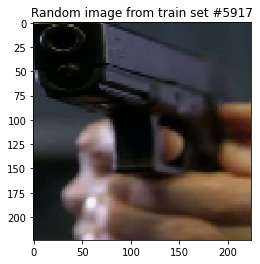

In [ ]:
random_img = np.random.randint(len(x_train))
plt.imshow(x_train[random_img].reshape(224,224,3))
plt.title(f'Random image from train set #{random_img}')

gun = 'label 1 -> gun'
no_gun = 'label 0 -> no gun'
if y_train[random_img][0] == 0:
  print(gun)
else:
  print(no_gun)

Function will create the model - InceptionV3 with the trained weights

In [10]:
def get_inceptionv3(dim):
    model = Sequential()
    base_model = InceptionV3(weights = 'imagenet', include_top = False)

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer of 128
    x = Dense(128, activation = 'relu')(x)
    # and a logistic layer - we have 2 classes
    predictions = Dense(2, activation = 'softmax')(x)
    
    # this is the model we will train
    model = Model(inputs = base_model.input, outputs=predictions)
    
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False

    # compile the model 
    model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy') 
    return model

Prevents overfitting and saves models every time the validation loss improves in file 'ModelWeight.h5'

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss', verbose = 1, patience = 10, min_delta = 0.00075)
model_checkpoint = ModelCheckpoint(r'/content/gdrive/MyDrive/Guns_Detection/ModelWeights.h5', verbose = 1, save_best_only = True, monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')
epochs = 50
batch_size = 32
model = get_inceptionv3(dim = (224,224, 3)) 

Training the model

In [ ]:
fit = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, 
                callbacks = [early_stopping, model_checkpoint, lr_plat],
                validation_data = (x_test, y_test), verbose= 1)

Epoch 1/50
190/190 [==============================] - 26s 110ms/step - loss: 0.2982 - val_loss: 0.1331

Epoch 00001: val_loss improved from inf to 0.13314, saving model to /content/gdrive/MyDrive/Guns_Detection/ModelWeights.h5
Epoch 2/50
190/190 [==============================] - 18s 95ms/step - loss: 0.1038 - val_loss: 0.1511

Epoch 00002: val_loss did not improve from 0.13314
Epoch 3/50
190/190 [==============================] - 18s 96ms/step - loss: 0.0989 - val_loss: 0.1014

Epoch 00003: val_loss improved from 0.13314 to 0.10141, saving model to /content/gdrive/MyDrive/Guns_Detection/ModelWeights.h5
Epoch 4/50
190/190 [==============================] - 18s 97ms/step - loss: 0.0779 - val_loss: 0.1096

Epoch 00004: val_loss did not improve from 0.10141
Epoch 5/50
190/190 [==============================] - 19s 98ms/step - loss: 0.0511 - val_loss: 0.1018

Epoch 00005: val_loss did not improve from 0.10141
Epoch 6/50
190/190 [==============================] - 19s 98ms/step - loss: 0.021

Plot of model loss

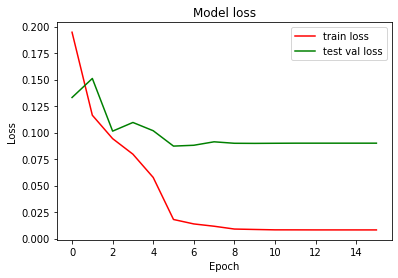

In [ ]:
plt.plot(fit.history['loss'], label='train loss', c = 'red')
plt.plot(fit.history['val_loss'], label='test val loss', c = 'green')
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.savefig('chart loss.png')

Function will predict if there is a weapon given in the image path and dimensions

In [11]:
def get_img_prediction(path, model, dim):
    img = get_image_value(path, dim)   
    img = img.reshape(1, img.shape[0], img.shape[1], 3)
    pred = model.predict(img)[0]
    category_dict = {0: 'No Gun', 1: 'Gun'}
    cat_index = np.argmax(pred)
    cat = category_dict[cat_index]
    print(f'Prediction: {cat}\t{int(pred.max()*100)}% Confident')
    img_show = plt.imshow(get_image_value(path, dim))
    return img_show    

Detect the weapon using our weights of incepionV3 model 

In [ ]:
dim = (224, 224, 3)   
inc_model = get_inceptionv3(dim)
inc_model.load_weights(r'/content/gdrive/MyDrive/Guns_Detection/ModelWeights.h5') 
predictions = []

Prediction: Gun	98% Confident


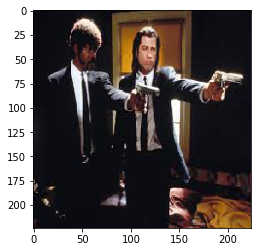

In [ ]:
img_path = r'/content/gdrive/MyDrive/Guns_Detection/Test/pulp_fiction.jpg'
pred = get_img_prediction(img_path, inc_model, dim = (224,224))
predictions.append(pred)

Prediction: No Gun	98% Confident


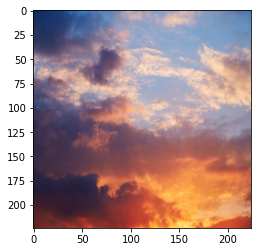

In [ ]:

img_path = r'/content/gdrive/MyDrive/Guns_Detection/Test/sky.jpeg'
pred = get_img_prediction(img_path, inc_model, dim = (224,224))
predictions.append(pred) 

Prediction: Gun	99% Confident


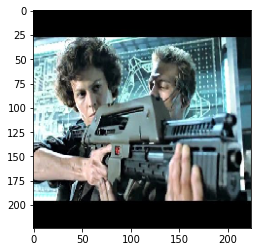

In [ ]:
img_path = r'/content/gdrive/MyDrive/Guns_Detection/Test/alien.jpg'
pred = get_img_prediction(img_path, inc_model, dim = (224,224))
predictions.append(pred)

Prediction: Gun	99% Confident


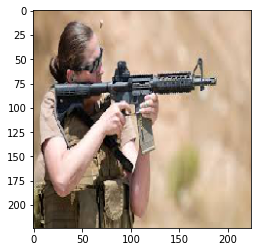

In [ ]:
img_path = r'/content/gdrive/MyDrive/Guns_Detection/Test/images.jpg'
pred = get_img_prediction(img_path, inc_model, dim = (224,224))
predictions.append(pred)